In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from astra.torch.models import ResNetClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn


/home/agarwal.aditi/miniconda3/envs/py39/lib/python3.9/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/agarwal.aditi/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
dict1 = {'Training set': [], 'train Accuracy': [], 'pool Accuracy': [], 'test Accuracy': [], 'train F1 Score': [], 'pool F1 Score': [], 'test F1 Score': []}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

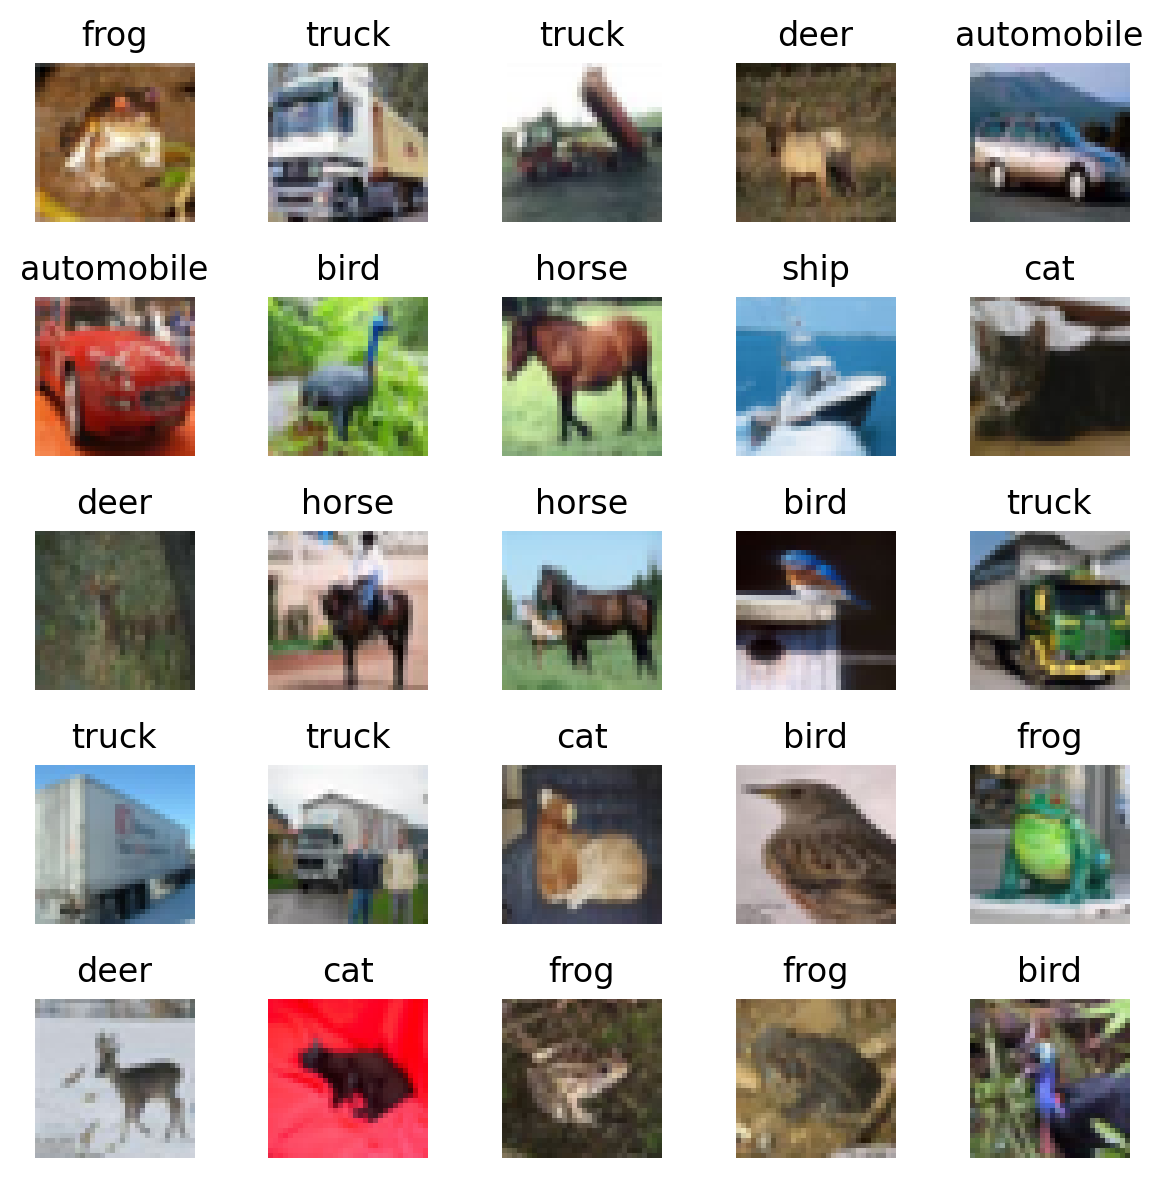

In [6]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis("off")
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [7]:
n_train = 1000
n_test = 20000
y = dataset.targets
X = dataset.data
# y = (y==1).int()
# mask=(y==1)
# X=X[mask]
print(y)

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

tensor([6, 9, 9,  ..., 5, 1, 7])
torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [8]:
classes = dataset.classes
class_1_idx = classes.index("frog")
print(class_1_idx)

6


In [9]:
class_1_mask = y == class_1_idx
print(class_1_mask)
class_1_mask = class_1_mask.int()
print(class_1_mask)
class_1_mask.shape
y = class_1_mask


tensor([ True, False, False,  ..., False, False, False])
tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


In [10]:
print(y)

tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


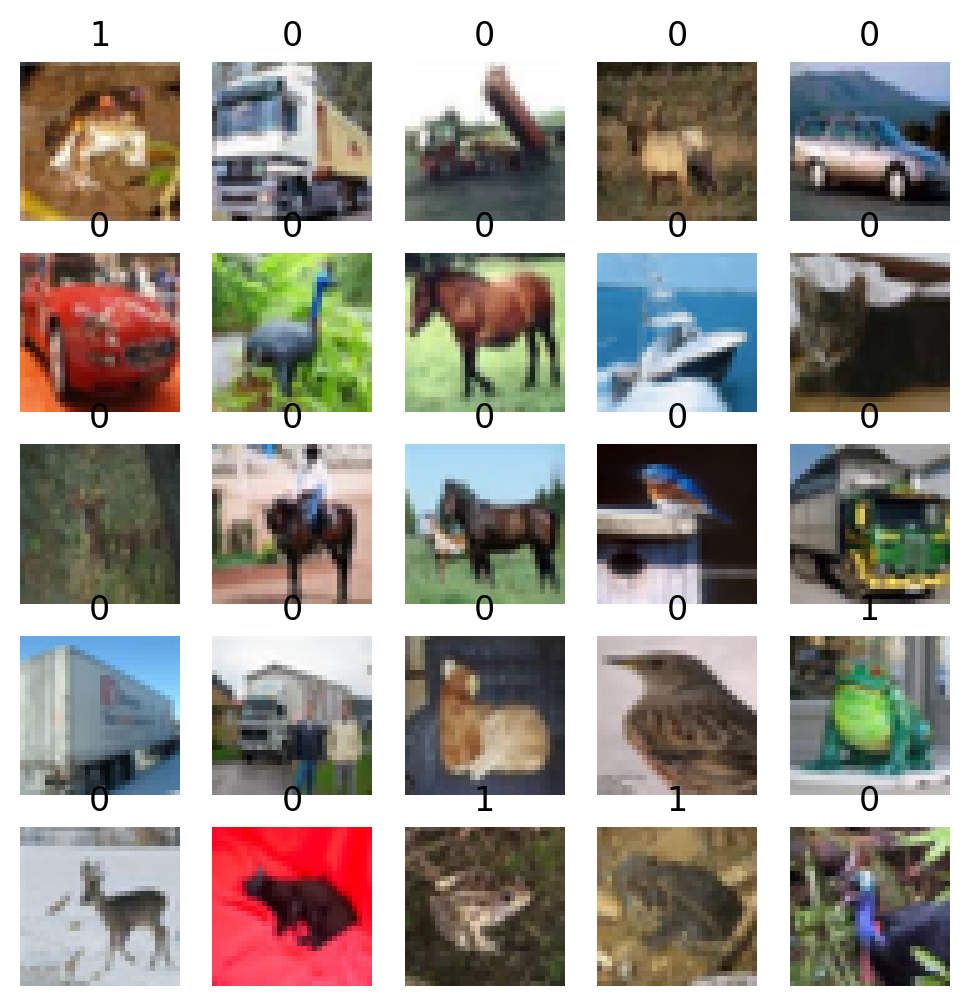

In [11]:
# plot some  images with the new labels in boolean print only label o or 1 not tensor (1,dtype=int64)
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.einsum("chw->hwc", X[i].cpu()))
    plt.axis("off")
    plt.title(y[i].item())

In [12]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [13]:
resnet = ResNetClassifier(
    models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=2
).to(device)
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [14]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

train set accuracy: 13.60%
1000 1000
              precision    recall  f1-score   support

           0       0.94      0.03      0.07       893
           1       0.11      0.98      0.20       107

    accuracy                           0.14      1000
   macro avg       0.52      0.51      0.13      1000
weighted avg       0.85      0.14      0.08      1000



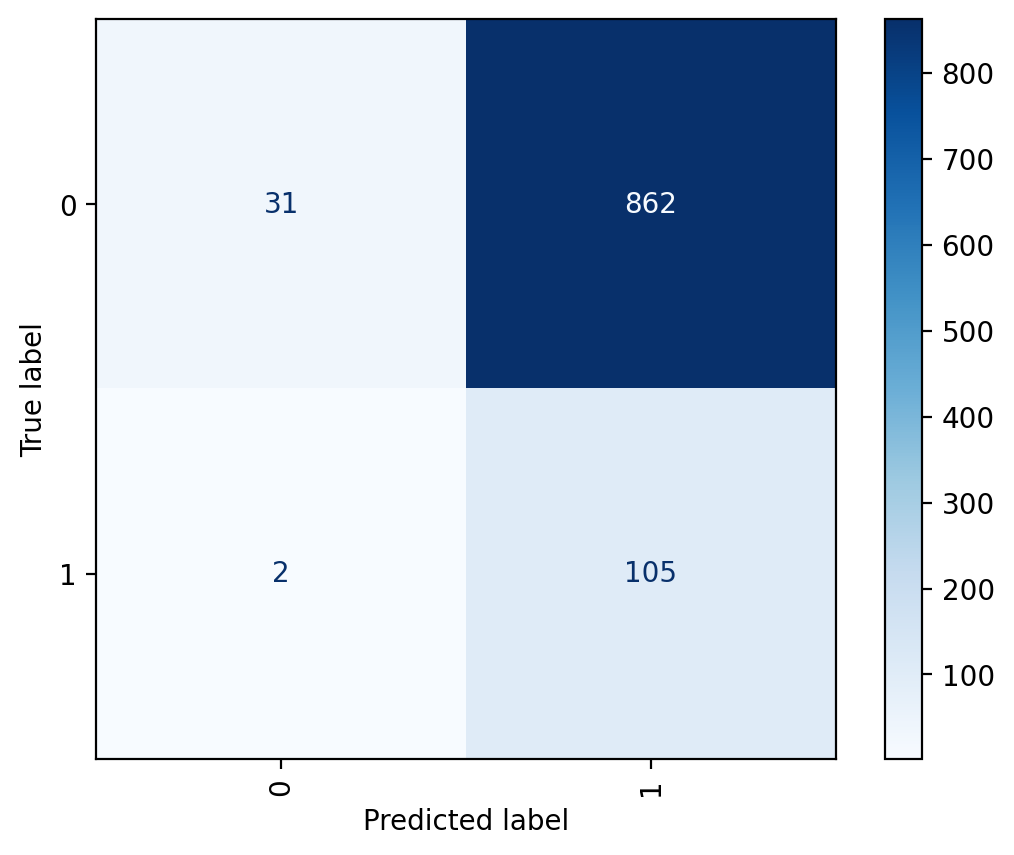

pool set accuracy: 13.01%
39000 39000
              precision    recall  f1-score   support

           0       0.90      0.04      0.07     35115
           1       0.10      0.96      0.18      3885

    accuracy                           0.13     39000
   macro avg       0.50      0.50      0.13     39000
weighted avg       0.82      0.13      0.08     39000



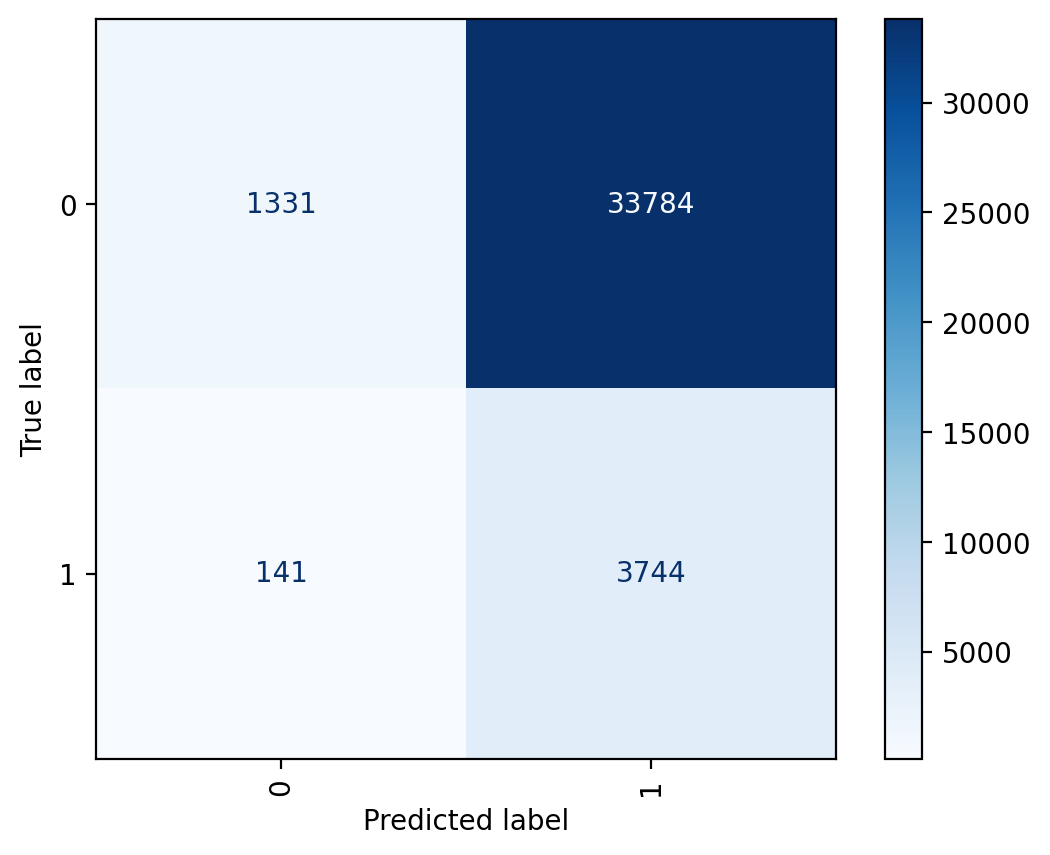

test set accuracy: 13.02%
20000 20000
              precision    recall  f1-score   support

           0       0.90      0.04      0.07     17992
           1       0.10      0.96      0.18      2008

    accuracy                           0.13     20000
   macro avg       0.50      0.50      0.13     20000
weighted avg       0.82      0.13      0.08     20000



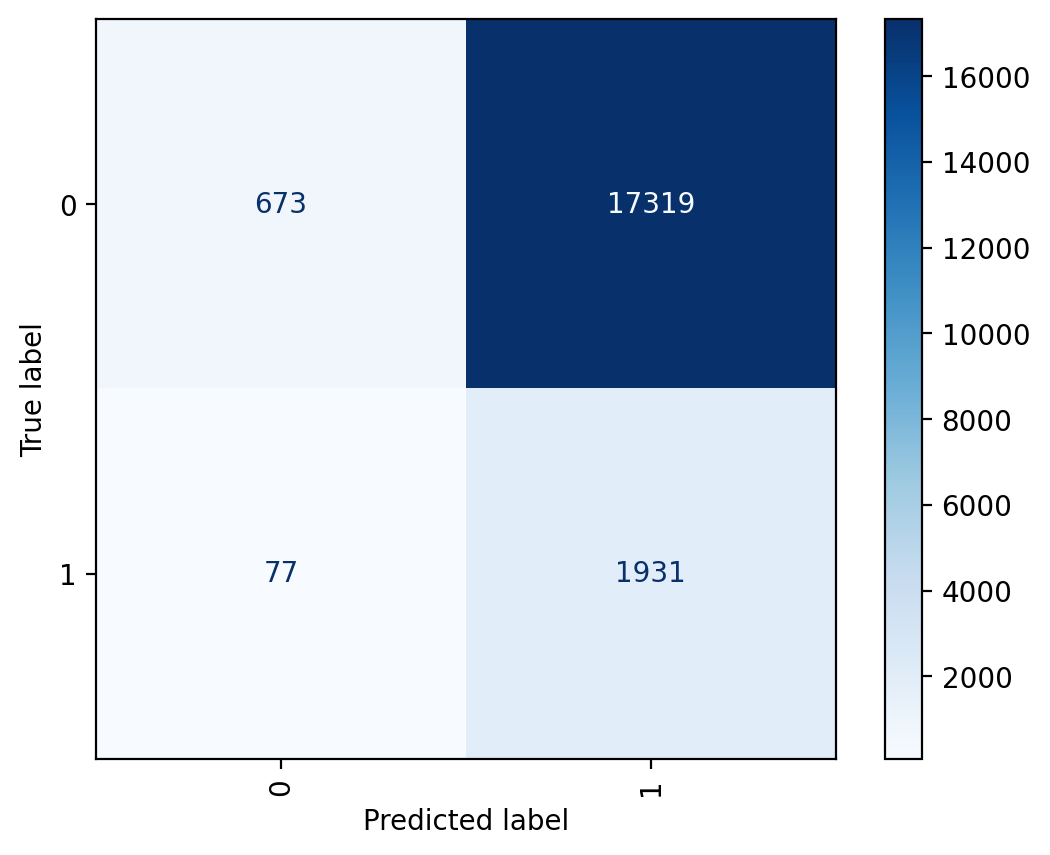

In [15]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc


def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(
        zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])
    ):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f"{name} set accuracy: {acc*100:.2f}%")
        
        # print the len of true and predicted labels
        print(len(y_dataset), len(y_pred))
        # print classification report
        from sklearn.metrics import classification_report

        print(classification_report(y_dataset.cpu(), y_pred.cpu()))
        dict1[name+' Accuracy'].append(acc*100)
        f1 = classification_report(y_dataset.cpu(), y_pred.cpu(), output_dict=True)['0']['f1-score']
        dict1[name+' F1 Score'].append(f1)
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(
                values_format="d", cmap="Blues"
            )
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()


predict(resnet, ["0", "1"], plot_confusion_matrix=True)

In [16]:
dict1

{'Training set': [],
 'train Accuracy': [tensor(13.6000, device='cuda:0')],
 'pool Accuracy': [tensor(13.0128, device='cuda:0')],
 'test Accuracy': [tensor(13.0200, device='cuda:0')],
 'train F1 Score': [0.06695464362850971],
 'pool F1 Score': [0.07275808347227158],
 'test F1 Score': [0.07181730871838651]}

/home/agarwal.aditi/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


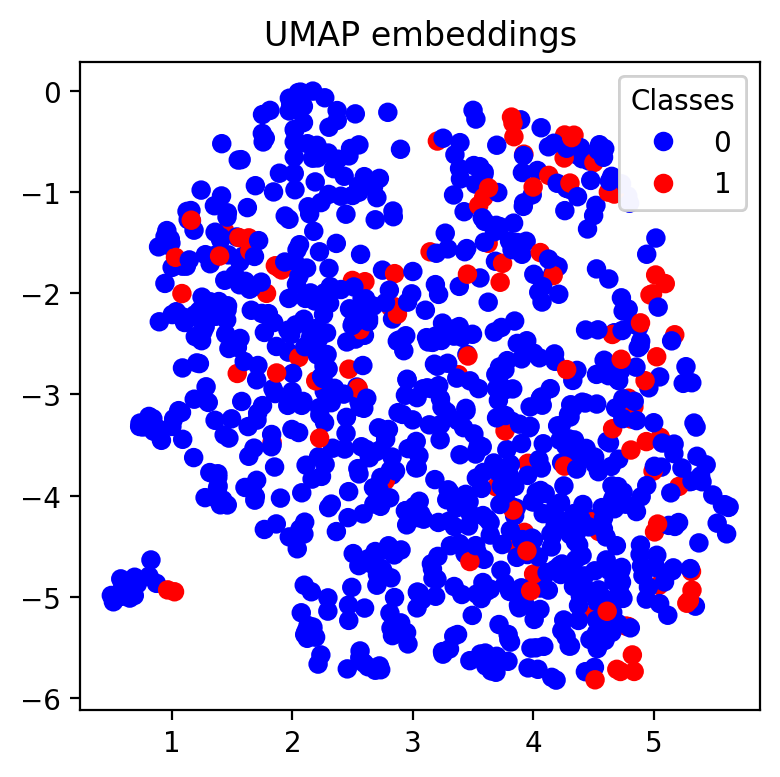

In [17]:
import umap


def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap="bwr")

    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.gca().add_artist(legend1)

    plt.title("UMAP embeddings")
    plt.tight_layout()
    plt.show()


viz_embeddings(resnet, X[train_idx], y[train_idx], device)

In [18]:
print(y[train_idx].shape)
print(X[train_idx].shape)

torch.Size([1000])
torch.Size([1000, 3, 32, 32])


In [19]:
resnet = ResNetClassifier(
    models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1
).to(device)

# Convert X to float and y to long
X_float = X[train_idx].float()
y_long = y[train_idx].long()

iter_losses, epoch_losses = train_fn(
    resnet,
    X_float,
    y_long,
    nn.CrossEntropyLoss(),
    lr=3e-4,
    batch_size=128,
    epochs=30,
    verbose=False,
)

Text(0, 0.5, 'Training loss')

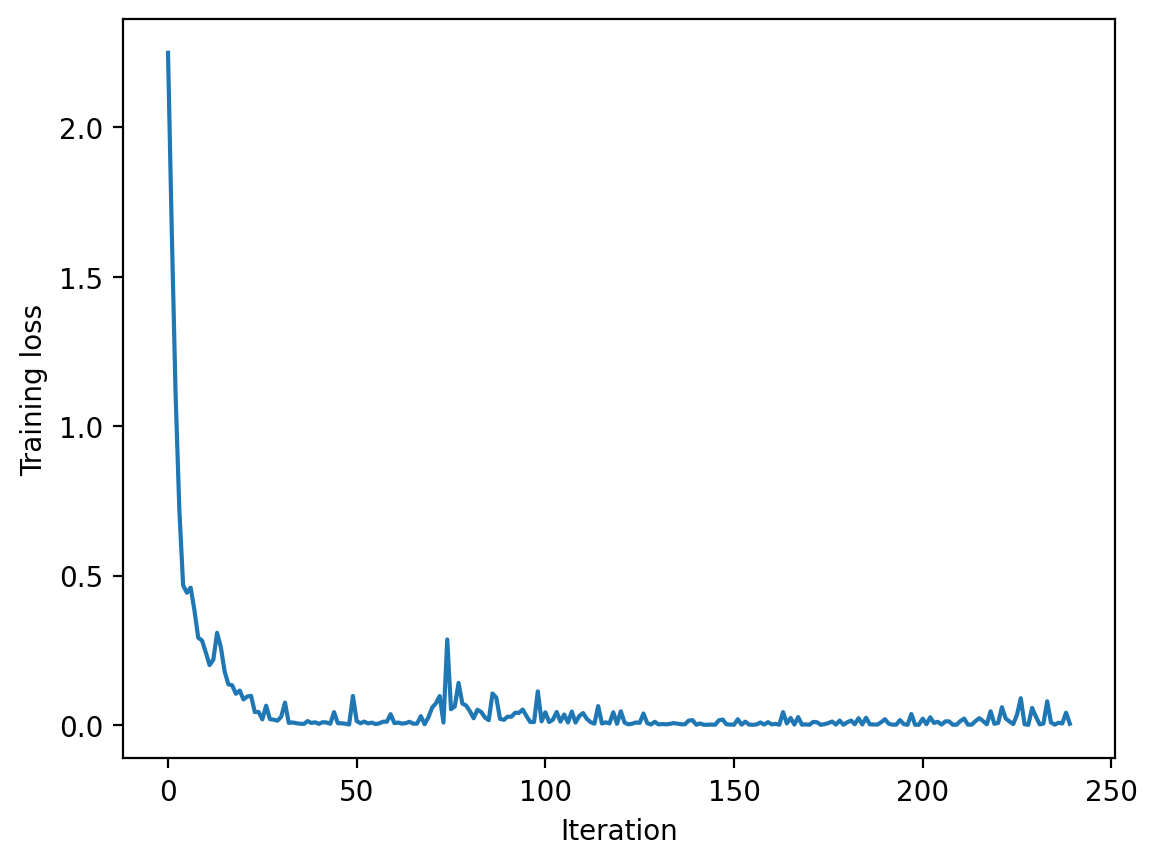

In [20]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



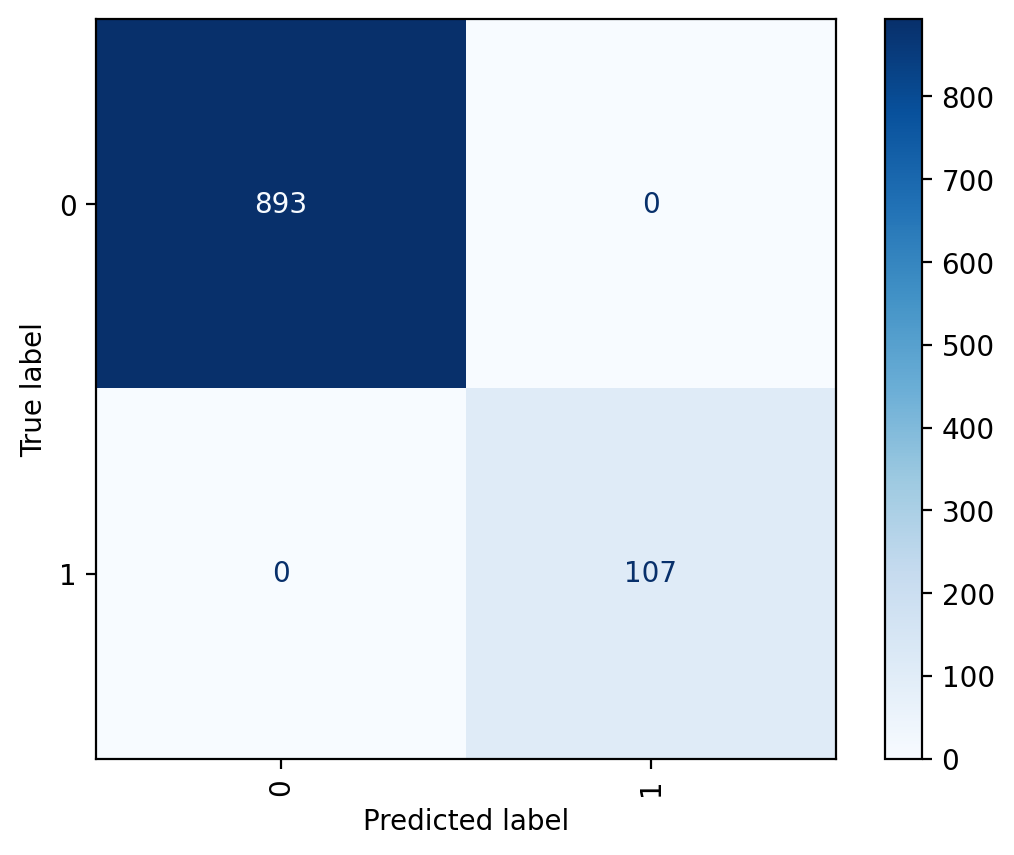

pool set accuracy: 88.91%
39000 39000
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     35115
           1       0.44      0.46      0.45      3885

    accuracy                           0.89     39000
   macro avg       0.69      0.70      0.69     39000
weighted avg       0.89      0.89      0.89     39000



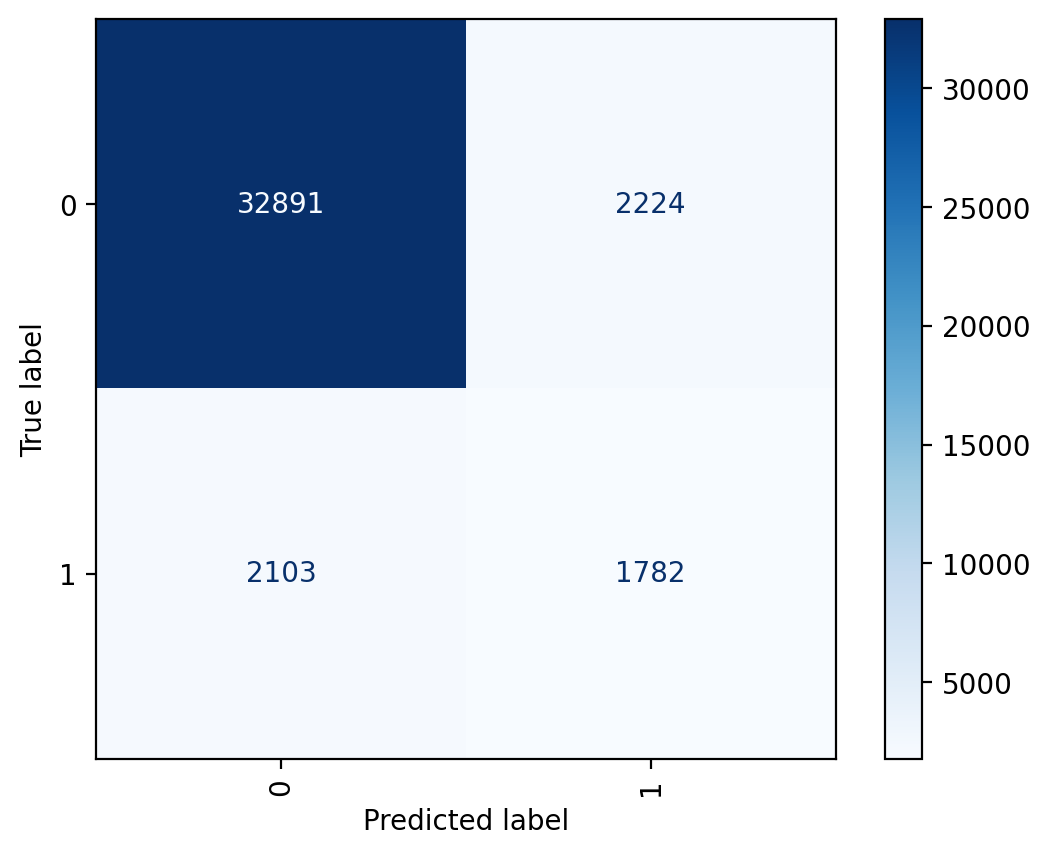

test set accuracy: 88.59%
20000 20000
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     17992
           1       0.43      0.45      0.44      2008

    accuracy                           0.89     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.89      0.89      0.89     20000



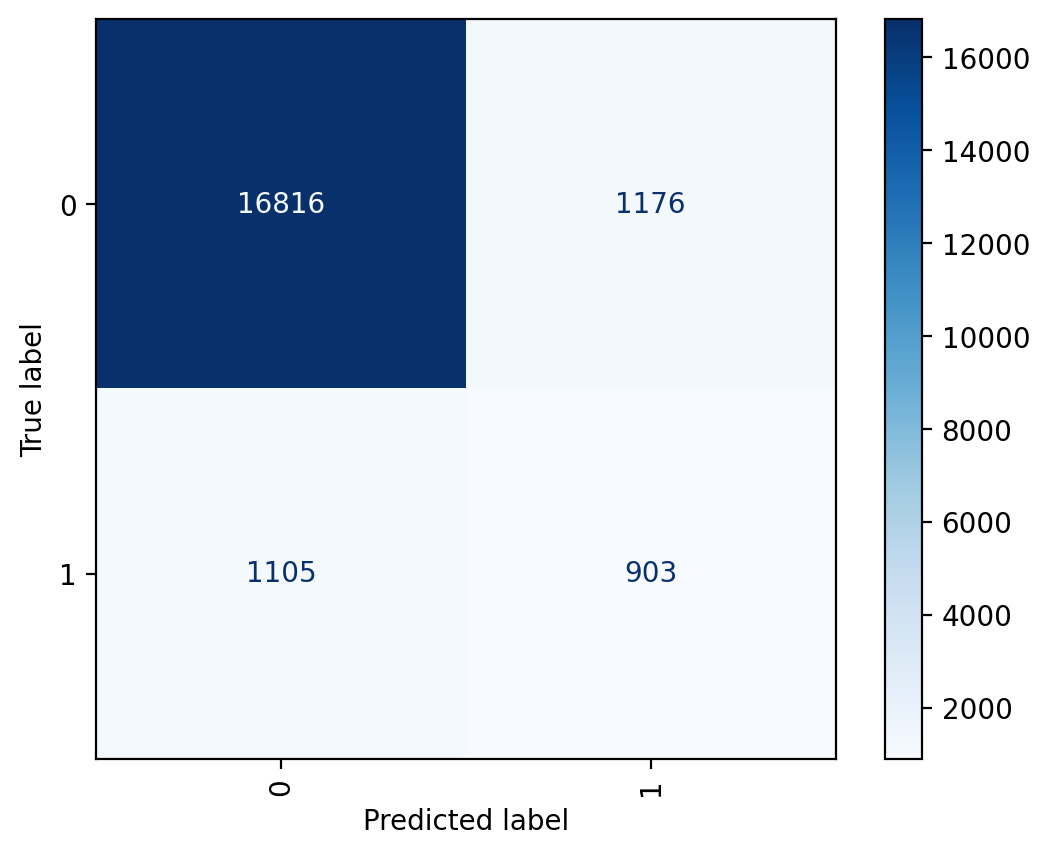

In [21]:
predict(resnet, ["0", "1"], plot_confusion_matrix=True)

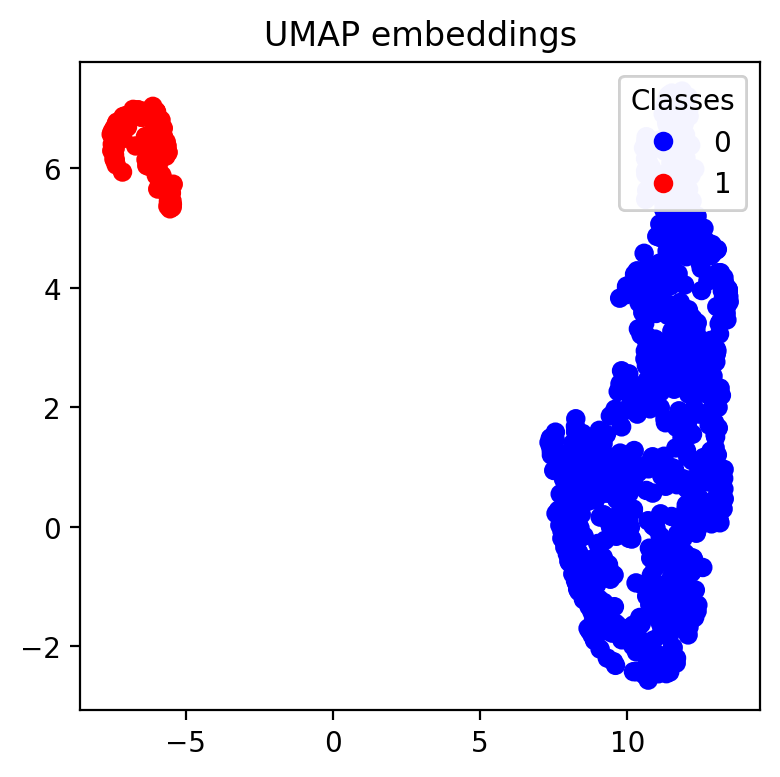

In [22]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

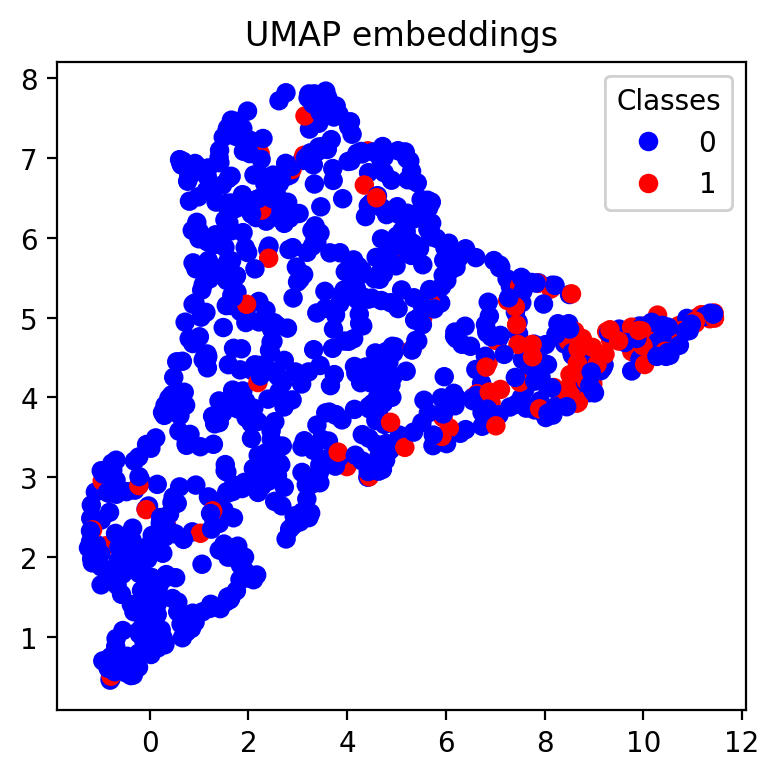

In [23]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [24]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)
# convert X to float and y to long
X_float = X[train_plus_pool_idx].float()
y_long = y[train_plus_pool_idx].long()

iter_losses, epoch_losses = train_fn(
    resnet,
    X_float,
    y_long,
    loss_fn=nn.CrossEntropyLoss(),
    lr=3e-4,
    batch_size=1024,
    epochs=30,
)

Loss: 0.286803: 100%|██████████| 40/40 [00:01<00:00, 34.10it/s]


Epoch 1: 0.25253699226379395


Loss: 0.105173: 100%|██████████| 40/40 [00:01<00:00, 37.55it/s]


Epoch 2: 0.1604686592102051


Loss: 0.060628: 100%|██████████| 40/40 [00:01<00:00, 37.36it/s]


Epoch 3: 0.1218209177017212


Loss: 0.105644: 100%|██████████| 40/40 [00:00<00:00, 48.06it/s]


Epoch 4: 0.09123610353469849


Loss: 0.042217: 100%|██████████| 40/40 [00:00<00:00, 48.05it/s]


Epoch 5: 0.08343535804748535


Loss: 0.034075: 100%|██████████| 40/40 [00:01<00:00, 36.23it/s]


Epoch 6: 0.06348516864776611


Loss: 0.041707: 100%|██████████| 40/40 [00:01<00:00, 37.00it/s]


Epoch 7: 0.04157478280067444


Loss: 0.036017: 100%|██████████| 40/40 [00:01<00:00, 38.16it/s]


Epoch 8: 0.045608080291748045


Loss: 0.022980: 100%|██████████| 40/40 [00:01<00:00, 36.09it/s]


Epoch 9: 0.03410432531833649


Loss: 0.002301: 100%|██████████| 40/40 [00:01<00:00, 37.44it/s]


Epoch 10: 0.0443265474319458


Loss: 0.007042: 100%|██████████| 40/40 [00:01<00:00, 39.77it/s]


Epoch 11: 0.012424137055873872


Loss: 0.002432: 100%|██████████| 40/40 [00:01<00:00, 37.43it/s]


Epoch 12: 0.016055351960659027


Loss: 0.017417: 100%|██████████| 40/40 [00:01<00:00, 38.22it/s]


Epoch 13: 0.007124566739797592


Loss: 0.007064: 100%|██████████| 40/40 [00:01<00:00, 37.49it/s]


Epoch 14: 0.028158892464637757


Loss: 0.034079: 100%|██████████| 40/40 [00:00<00:00, 49.61it/s]


Epoch 15: 0.011700102972984313


Loss: 0.009595: 100%|██████████| 40/40 [00:00<00:00, 41.17it/s]


Epoch 16: 0.03005141727924347


Loss: 0.003677: 100%|██████████| 40/40 [00:01<00:00, 36.01it/s]


Epoch 17: 0.009091123300790786


Loss: 0.039268: 100%|██████████| 40/40 [00:01<00:00, 37.43it/s]


Epoch 18: 0.010269414728879928


Loss: 0.015781: 100%|██████████| 40/40 [00:01<00:00, 38.78it/s]


Epoch 19: 0.03789965119361877


Loss: 0.000276: 100%|██████████| 40/40 [00:00<00:00, 48.63it/s]


Epoch 20: 0.010391440238058568


Loss: 0.000875: 100%|██████████| 40/40 [00:01<00:00, 37.45it/s]


Epoch 21: 0.004321710225939751


Loss: 0.000067: 100%|██████████| 40/40 [00:01<00:00, 38.70it/s]


Epoch 22: 0.0027508975364267827


Loss: 0.010740: 100%|██████████| 40/40 [00:01<00:00, 37.18it/s]


Epoch 23: 0.004525077387690544


Loss: 0.012131: 100%|██████████| 40/40 [00:00<00:00, 40.15it/s]


Epoch 24: 0.015516837912797928


Loss: 0.008760: 100%|██████████| 40/40 [00:01<00:00, 38.42it/s]


Epoch 25: 0.011903412914276122


Loss: 0.001001: 100%|██████████| 40/40 [00:00<00:00, 44.00it/s]


Epoch 26: 0.00784135225713253


Loss: 0.000139: 100%|██████████| 40/40 [00:01<00:00, 39.64it/s]


Epoch 27: 0.003327411177754402


Loss: 0.004109: 100%|██████████| 40/40 [00:00<00:00, 43.57it/s]


Epoch 28: 0.002792512473464012


Loss: 0.000970: 100%|██████████| 40/40 [00:00<00:00, 49.66it/s]


Epoch 29: 0.005145423101633787


Loss: 0.021946: 100%|██████████| 40/40 [00:01<00:00, 39.01it/s]

Epoch 30: 0.006991027165949345


Text(0, 0.5, 'Training loss')

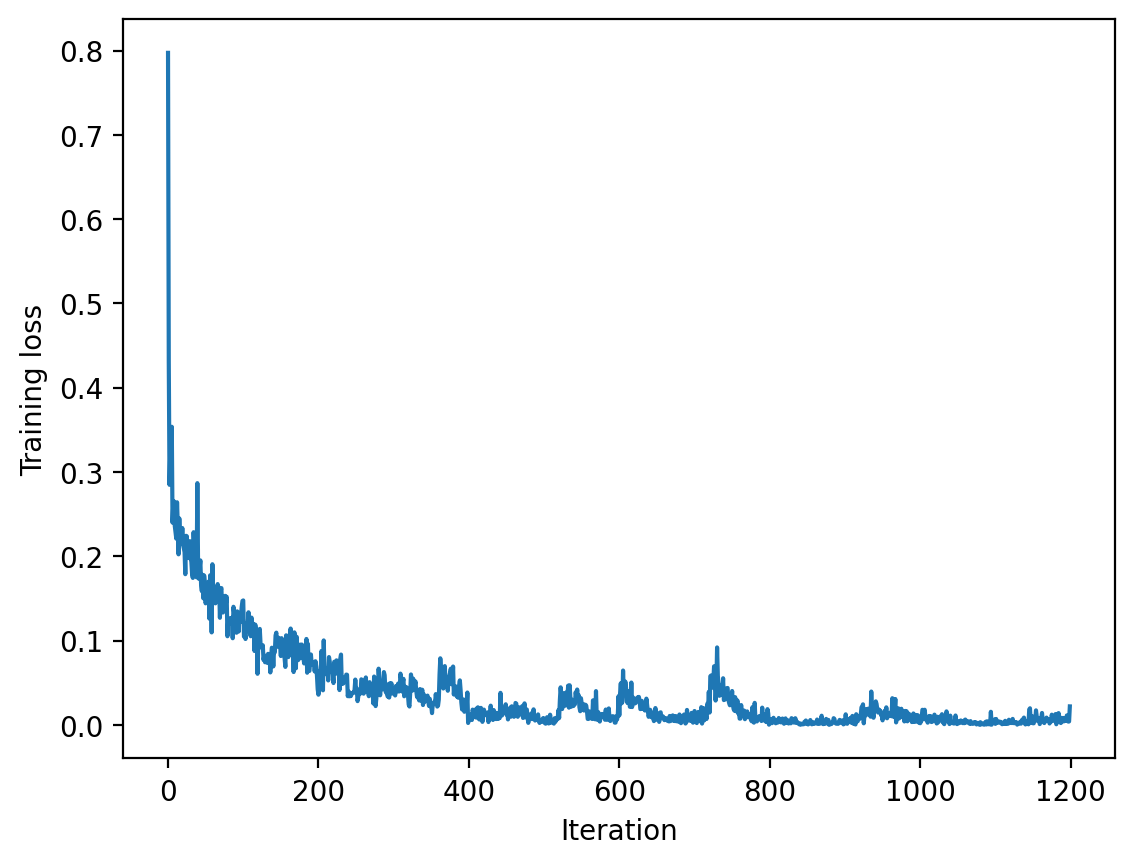

In [25]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

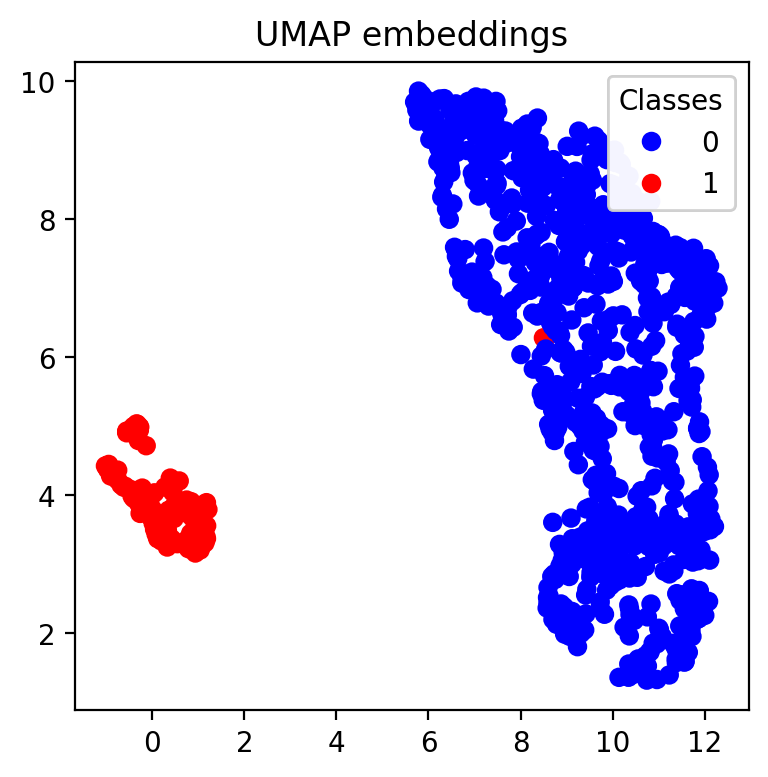

In [26]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

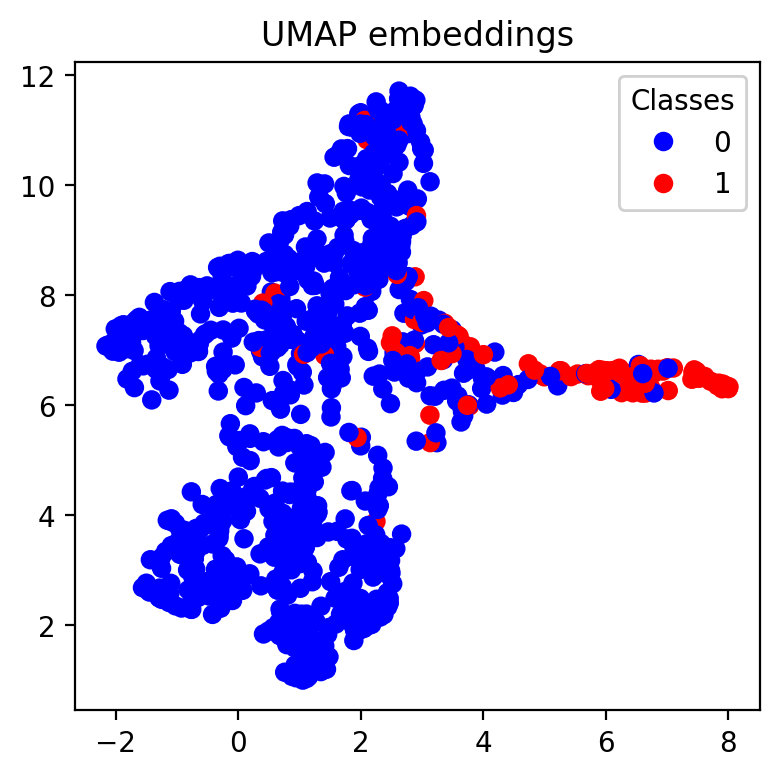

In [27]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.80%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       0.99      0.99      0.99       107

    accuracy                           1.00      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       1.00      1.00      1.00      1000



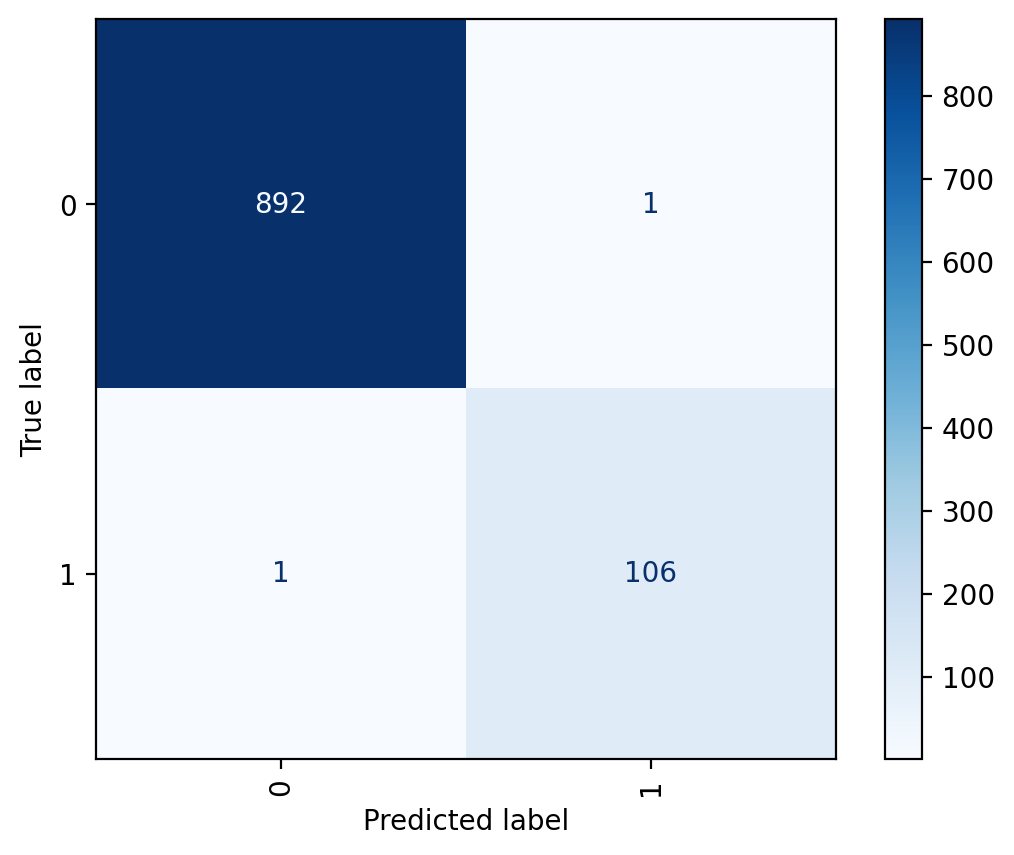

pool set accuracy: 99.79%
39000 39000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35115
           1       0.99      0.99      0.99      3885

    accuracy                           1.00     39000
   macro avg       0.99      0.99      0.99     39000
weighted avg       1.00      1.00      1.00     39000



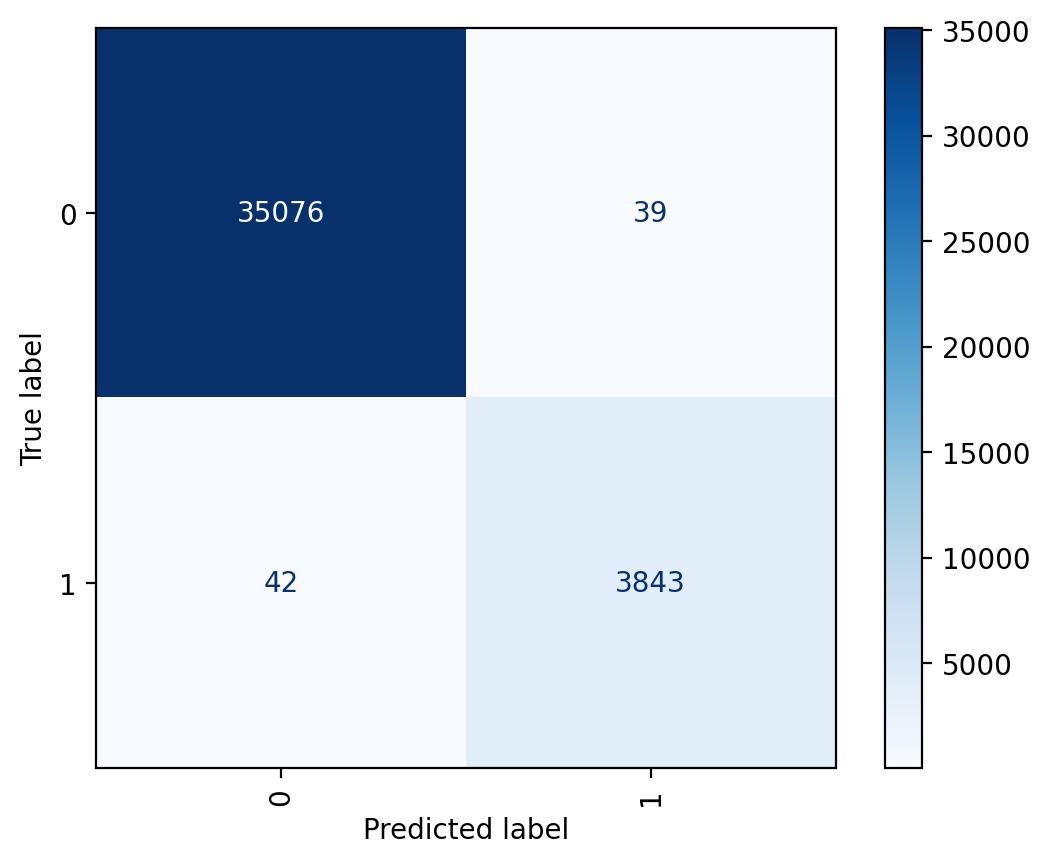

test set accuracy: 93.81%
20000 20000
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17992
           1       0.70      0.66      0.68      2008

    accuracy                           0.94     20000
   macro avg       0.83      0.82      0.82     20000
weighted avg       0.94      0.94      0.94     20000



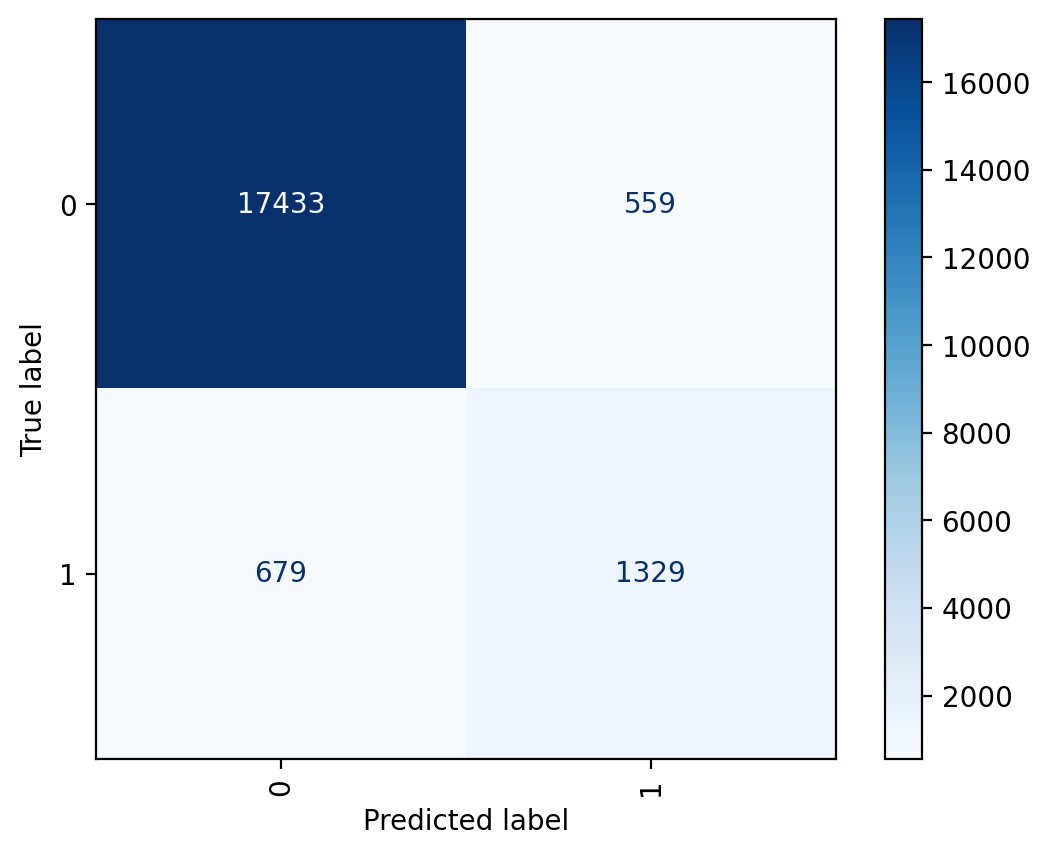

In [28]:
predict(resnet, ["0", "1"], plot_confusion_matrix=True)

## SSL

In [29]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [30]:
import itertools
import tqdm
X_ssl_split = []
y_ssl_split = []

label = [0,1,2,3]
label_permute = list(itertools.permutations(label))
h = 32
w = 32

for i in tqdm.tqdm(range(len(X_train_plus_pool))):
    img_part = np.zeros((4, 3, h // 2, w // 2))
    img = X_train_plus_pool[i]
    img_part[0] = img[:, : h // 2, : w // 2]
    img_part[1] = img[:, h // 2 :, : w // 2]
    img_part[2] = img[:, : h // 2, w // 2 :]
    img_part[3] = img[:, h // 2 :, w // 2 :]
    for j,k in zip(label_permute, range(len(label_permute))):
        top_half = np.concatenate((img_part[j[0]], img_part[j[2]]), axis=2)
    # Combine the bottom-left and bottom-right parts
        bottom_half = np.concatenate((img_part[j[1]], img_part[j[3]]), axis=2)

    # Combine the top and bottom halves to create the final stitched image
        stitched_image = np.concatenate((top_half, bottom_half), axis=1)
        X_ssl_split.append(torch.tensor(stitched_image, dtype=torch.float32))
        y_ssl_split.append(torch.tensor(k))





100%|██████████| 40000/40000 [00:31<00:00, 1287.95it/s]


In [68]:
X_test

NameError: name 'X_test' is not defined

In [31]:
y_ssl_split = torch.stack(y_ssl_split)

In [32]:
len(X_ssl_split)

960000

In [34]:
# y_ssl_split = torch.cat(y_ssl_split)
X_ssl_split_new = torch.stack(X_ssl_split)

In [ ]:
X_ssl = []
y_ssl = []

angles_map = {0: 0, 90: 1, 180: 2, 270: 3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    print(X_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]] * len(X_rot)))

X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

Angle: 0
tensor([[[[0.5451, 0.5608, 0.5725,  ..., 0.5569, 0.5804, 0.5843],
          [0.4863, 0.4863, 0.5294,  ..., 0.6235, 0.6039, 0.5961],
          [0.5255, 0.5059, 0.5333,  ..., 0.5765, 0.5922, 0.6549],
          ...,
          [0.5098, 0.5765, 0.5529,  ..., 0.6235, 0.5922, 0.5608],
          [0.6275, 0.5843, 0.5686,  ..., 0.5922, 0.6235, 0.5294],
          [0.5686, 0.5843, 0.5686,  ..., 0.6196, 0.5725, 0.5647]],

         [[0.4588, 0.4706, 0.4706,  ..., 0.4667, 0.4902, 0.4980],
          [0.4039, 0.3961, 0.4275,  ..., 0.5255, 0.5059, 0.5020],
          [0.4392, 0.4157, 0.4314,  ..., 0.4706, 0.4902, 0.5490],
          ...,
          [0.4078, 0.4667, 0.4314,  ..., 0.5059, 0.4745, 0.4471],
          [0.5216, 0.4745, 0.4471,  ..., 0.4667, 0.4980, 0.4039],
          [0.4627, 0.4706, 0.4471,  ..., 0.4824, 0.4431, 0.4353]],

         [[0.3961, 0.4078, 0.4118,  ..., 0.4000, 0.4118, 0.4157],
          [0.3373, 0.3333, 0.3686,  ..., 0.4627, 0.4314, 0.4196],
          [0.3725, 0.3529, 0.3725

In [ ]:
X_ssl

tensor([[[[0.5451, 0.5608, 0.5725,  ..., 0.5569, 0.5804, 0.5843],
          [0.4863, 0.4863, 0.5294,  ..., 0.6235, 0.6039, 0.5961],
          [0.5255, 0.5059, 0.5333,  ..., 0.5765, 0.5922, 0.6549],
          ...,
          [0.5098, 0.5765, 0.5529,  ..., 0.6235, 0.5922, 0.5608],
          [0.6275, 0.5843, 0.5686,  ..., 0.5922, 0.6235, 0.5294],
          [0.5686, 0.5843, 0.5686,  ..., 0.6196, 0.5725, 0.5647]],

         [[0.4588, 0.4706, 0.4706,  ..., 0.4667, 0.4902, 0.4980],
          [0.4039, 0.3961, 0.4275,  ..., 0.5255, 0.5059, 0.5020],
          [0.4392, 0.4157, 0.4314,  ..., 0.4706, 0.4902, 0.5490],
          ...,
          [0.4078, 0.4667, 0.4314,  ..., 0.5059, 0.4745, 0.4471],
          [0.5216, 0.4745, 0.4471,  ..., 0.4667, 0.4980, 0.4039],
          [0.4627, 0.4706, 0.4471,  ..., 0.4824, 0.4431, 0.4353]],

         [[0.3961, 0.4078, 0.4118,  ..., 0.4000, 0.4118, 0.4157],
          [0.3373, 0.3333, 0.3686,  ..., 0.4627, 0.4314, 0.4196],
          [0.3725, 0.3529, 0.3725,  ..., 0

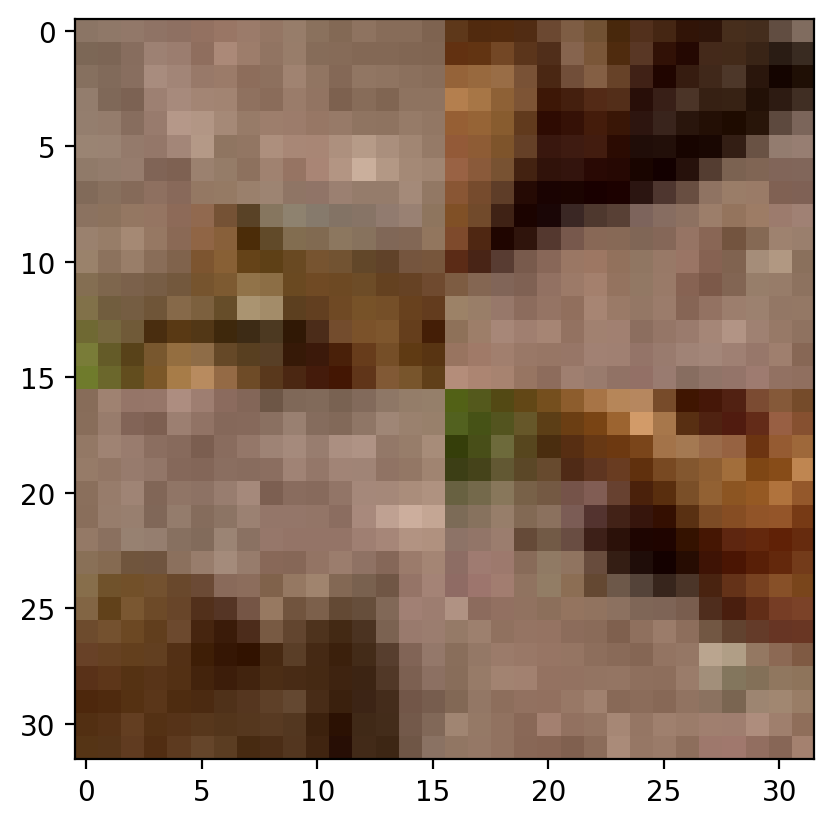

In [35]:
plt.imshow(np.array(X_ssl_split_new)[3].transpose(1, 2, 0))


In [36]:
ssl_permute = ResNetClassifier(
    models.resnet18, None, n_classes=24, activation=nn.GELU(), dropout=0.1
).to(device)

In [37]:
iter_losses, epoch_losses = train_fn(
    ssl_permute,
    X_ssl_split_new,
    y_ssl_split,
    lr=3e-4,
    loss_fn=nn.CrossEntropyLoss(),
    batch_size=1024,
    epochs=20,
)

Loss: 3.213601:   0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.240988: 100%|██████████| 938/938 [00:26<00:00, 35.96it/s]


Epoch 1: 0.6171347177028657


Loss: 0.174150: 100%|██████████| 938/938 [00:25<00:00, 36.31it/s]


Epoch 2: 0.18962115483283998


Loss: 0.140032: 100%|██████████| 938/938 [00:26<00:00, 35.96it/s]


Epoch 3: 0.12101879529158274


Loss: 0.089712: 100%|██████████| 938/938 [00:25<00:00, 36.55it/s]


Epoch 4: 0.08594556305011114


Loss: 0.048236: 100%|██████████| 938/938 [00:25<00:00, 37.33it/s]


Epoch 5: 0.06530749994119009


Loss: 0.059852: 100%|██████████| 938/938 [00:23<00:00, 39.57it/s]


Epoch 6: 0.05113759429852168


Loss: 0.050059: 100%|██████████| 938/938 [00:21<00:00, 43.45it/s]


Epoch 7: 0.042083588937918345


Loss: 0.032981: 100%|██████████| 938/938 [00:22<00:00, 42.08it/s]


Epoch 8: 0.03544348661204179


Loss: 0.042921: 100%|██████████| 938/938 [00:23<00:00, 40.73it/s]


Epoch 9: 0.02979384979605675


Loss: 0.017539: 100%|██████████| 938/938 [00:21<00:00, 44.16it/s]


Epoch 10: 0.026417945704857507


Loss: 0.040041: 100%|██████████| 938/938 [00:22<00:00, 42.01it/s]


Epoch 11: 0.023165468327204387


Loss: 0.035281: 100%|██████████| 938/938 [00:23<00:00, 40.59it/s]


Epoch 12: 0.02143617829233408


Loss: 0.016366: 100%|██████████| 938/938 [00:22<00:00, 41.84it/s]


Epoch 13: 0.019367483248313267


Loss: 0.010510: 100%|██████████| 938/938 [00:23<00:00, 40.39it/s]


Epoch 14: 0.01744544026826819


Loss: 0.010210: 100%|██████████| 938/938 [00:22<00:00, 42.48it/s]


Epoch 15: 0.01616523212964336


Loss: 0.017128: 100%|██████████| 938/938 [00:23<00:00, 40.16it/s]


Epoch 16: 0.015005224327246347


Loss: 0.011741: 100%|██████████| 938/938 [00:25<00:00, 37.18it/s]


Epoch 17: 0.014259116229911646


Loss: 0.016720: 100%|██████████| 938/938 [00:24<00:00, 38.73it/s]


Epoch 18: 0.013213500374803941


Loss: 0.022071: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]


Epoch 19: 0.01229992486263315


Loss: 0.017284: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]


Epoch 20: 0.011732803354163964


Text(0, 0.5, 'Training loss')

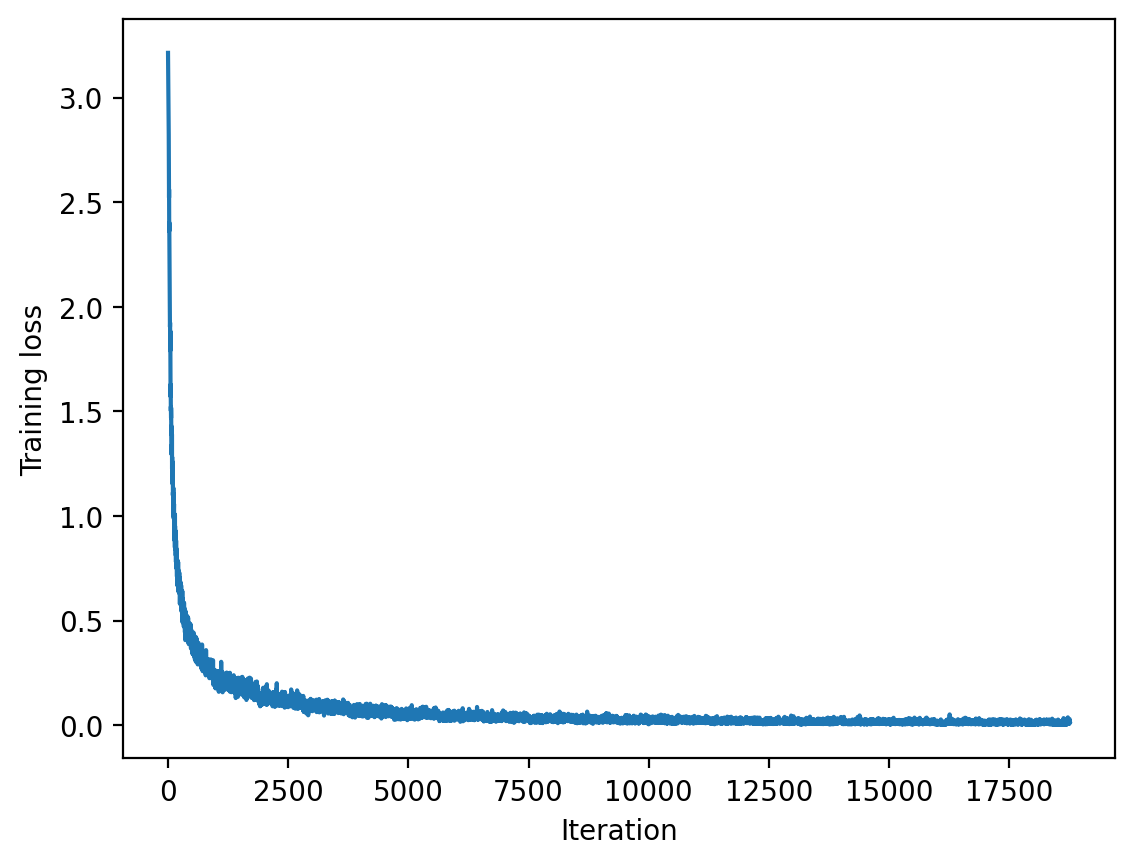

In [38]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

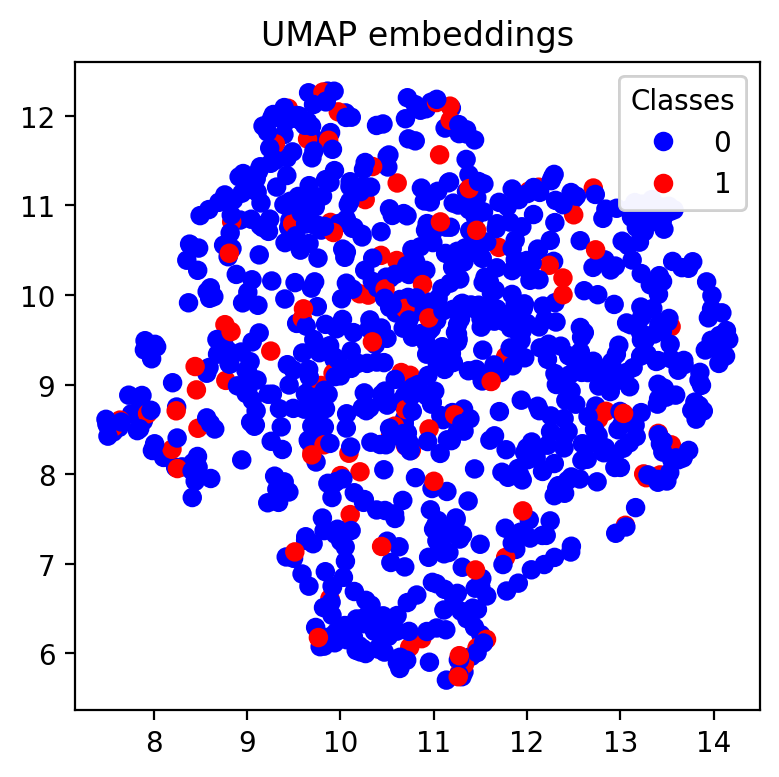

In [39]:
# Visualise the embeddings of the SSL model trained on angles dataset
# (but wrt original 10 classes)
viz_embeddings(ssl_permute, X[train_idx], y[train_idx], device)

In [40]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)
net_pretrained.featurizer.load_state_dict(ssl_permute.featurizer.state_dict())
# convert X to float and y to long
X_float = X[train_idx].float()
y_long = y[train_idx].long()

print(y_long)

iter_losses, epoch_losses = train_fn(
    net_pretrained,
    X_float,
    y_long,
    nn.CrossEntropyLoss(),
    lr=3e-4,
    epochs=50,
    batch_size=128,
)

tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

Loss: 0.405425:   0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.453043: 100%|██████████| 8/8 [00:00<00:00, 41.60it/s]


Epoch 1: 0.48546701049804686


Loss: 0.295518: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s]


Epoch 2: 0.27954974174499514


Loss: 0.172087: 100%|██████████| 8/8 [00:00<00:00, 41.30it/s]


Epoch 3: 0.2018494758605957


Loss: 0.114795: 100%|██████████| 8/8 [00:00<00:00, 44.10it/s]


Epoch 4: 0.13645738697052


Loss: 0.049917: 100%|██████████| 8/8 [00:00<00:00, 42.65it/s]


Epoch 5: 0.07002965927124023


Loss: 0.013507: 100%|██████████| 8/8 [00:00<00:00, 35.97it/s]


Epoch 6: 0.024817502617836


Loss: 0.005621: 100%|██████████| 8/8 [00:00<00:00, 48.36it/s]


Epoch 7: 0.007343930840492249


Loss: 0.001209: 100%|██████████| 8/8 [00:00<00:00, 45.26it/s]


Epoch 8: 0.0025425116568803786


Loss: 0.002477: 100%|██████████| 8/8 [00:00<00:00, 42.31it/s]


Epoch 9: 0.0012841996327042579


Loss: 0.000665: 100%|██████████| 8/8 [00:00<00:00, 57.07it/s]


Epoch 10: 0.0006303828060626983


Loss: 0.000594: 100%|██████████| 8/8 [00:00<00:00, 59.17it/s]


Epoch 11: 0.00046550631895661353


Loss: 0.000333: 100%|██████████| 8/8 [00:00<00:00, 48.66it/s]


Epoch 12: 0.00035847781971096995


Loss: 0.000279: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s]


Epoch 13: 0.000288165895268321


Loss: 0.000256: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s]


Epoch 14: 0.000275166941806674


Loss: 0.000194: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s]


Epoch 15: 0.0002313893586397171


Loss: 0.000172: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s]


Epoch 16: 0.0002366697434335947


Loss: 0.000549: 100%|██████████| 8/8 [00:00<00:00, 44.96it/s]


Epoch 17: 0.00024045553617179394


Loss: 0.000189: 100%|██████████| 8/8 [00:00<00:00, 43.78it/s]


Epoch 18: 0.00018933881446719168


Loss: 0.000157: 100%|██████████| 8/8 [00:00<00:00, 46.77it/s]


Epoch 19: 0.00017898880410939456


Loss: 0.000105: 100%|██████████| 8/8 [00:00<00:00, 41.35it/s]


Epoch 20: 0.00016643650364130735


Loss: 0.000214: 100%|██████████| 8/8 [00:00<00:00, 39.59it/s]


Epoch 21: 0.00016603756044059992


Loss: 0.000173: 100%|██████████| 8/8 [00:00<00:00, 44.93it/s]


Epoch 22: 0.00014460142329335212


Loss: 0.000148: 100%|██████████| 8/8 [00:00<00:00, 57.92it/s]


Epoch 23: 0.00013795297592878342


Loss: 0.000097: 100%|██████████| 8/8 [00:00<00:00, 58.06it/s]


Epoch 24: 0.00012601370085030795


Loss: 0.000118: 100%|██████████| 8/8 [00:00<00:00, 45.35it/s]


Epoch 25: 0.00013859179336577653


Loss: 0.000168: 100%|██████████| 8/8 [00:00<00:00, 44.44it/s]


Epoch 26: 0.0001402835100889206


Loss: 0.000232: 100%|██████████| 8/8 [00:00<00:00, 46.46it/s]


Epoch 27: 0.00010984721127897501


Loss: 0.000113: 100%|██████████| 8/8 [00:00<00:00, 44.08it/s]


Epoch 28: 9.02053453028202e-05


Loss: 0.000069: 100%|██████████| 8/8 [00:00<00:00, 46.06it/s]


Epoch 29: 0.00010112577863037586


Loss: 0.000087: 100%|██████████| 8/8 [00:00<00:00, 46.56it/s]


Epoch 30: 7.996752951294184e-05


Loss: 0.000058: 100%|██████████| 8/8 [00:00<00:00, 45.29it/s]


Epoch 31: 7.912496477365494e-05


Loss: 0.000078: 100%|██████████| 8/8 [00:00<00:00, 46.06it/s]


Epoch 32: 9.043904533609749e-05


Loss: 0.000064: 100%|██████████| 8/8 [00:00<00:00, 50.88it/s]


Epoch 33: 6.904229382053017e-05


Loss: 0.000059: 100%|██████████| 8/8 [00:00<00:00, 47.59it/s]


Epoch 34: 6.765861436724663e-05


Loss: 0.000080: 100%|██████████| 8/8 [00:00<00:00, 45.37it/s]


Epoch 35: 6.533179245889187e-05


Loss: 0.000068: 100%|██████████| 8/8 [00:00<00:00, 47.93it/s]


Epoch 36: 7.194468658417463e-05


Loss: 0.000082: 100%|██████████| 8/8 [00:00<00:00, 44.48it/s]


Epoch 37: 6.228022510185838e-05


Loss: 0.000053: 100%|██████████| 8/8 [00:00<00:00, 47.85it/s]


Epoch 38: 5.447652610018849e-05


Loss: 0.000072: 100%|██████████| 8/8 [00:00<00:00, 46.55it/s]


Epoch 39: 7.573211751878261e-05


Loss: 0.000085: 100%|██████████| 8/8 [00:00<00:00, 44.62it/s]


Epoch 40: 6.137709971517324e-05


Loss: 0.000065: 100%|██████████| 8/8 [00:00<00:00, 47.06it/s]


Epoch 41: 5.276855593547225e-05


Loss: 0.000070: 100%|██████████| 8/8 [00:00<00:00, 48.36it/s]


Epoch 42: 5.3266817703843115e-05


Loss: 0.000105: 100%|██████████| 8/8 [00:00<00:00, 47.82it/s]


Epoch 43: 6.94452584721148e-05


Loss: 0.000051: 100%|██████████| 8/8 [00:00<00:00, 43.59it/s]


Epoch 44: 4.0311071556061506e-05


Loss: 0.000038: 100%|██████████| 8/8 [00:00<00:00, 44.26it/s]


Epoch 45: 4.674984561279416e-05


Loss: 0.000029: 100%|██████████| 8/8 [00:00<00:00, 42.78it/s]


Epoch 46: 4.489899519830942e-05


Loss: 0.000065: 100%|██████████| 8/8 [00:00<00:00, 45.21it/s]


Epoch 47: 4.777729278430343e-05


Loss: 0.000048: 100%|██████████| 8/8 [00:00<00:00, 51.38it/s]


Epoch 48: 3.865699283778667e-05


Loss: 0.000035: 100%|██████████| 8/8 [00:00<00:00, 65.33it/s]


Epoch 49: 4.435974545776844e-05


Loss: 0.000028: 100%|██████████| 8/8 [00:00<00:00, 56.33it/s]

Epoch 50: 3.724765055812895e-05


Text(0, 0.5, 'Training loss')

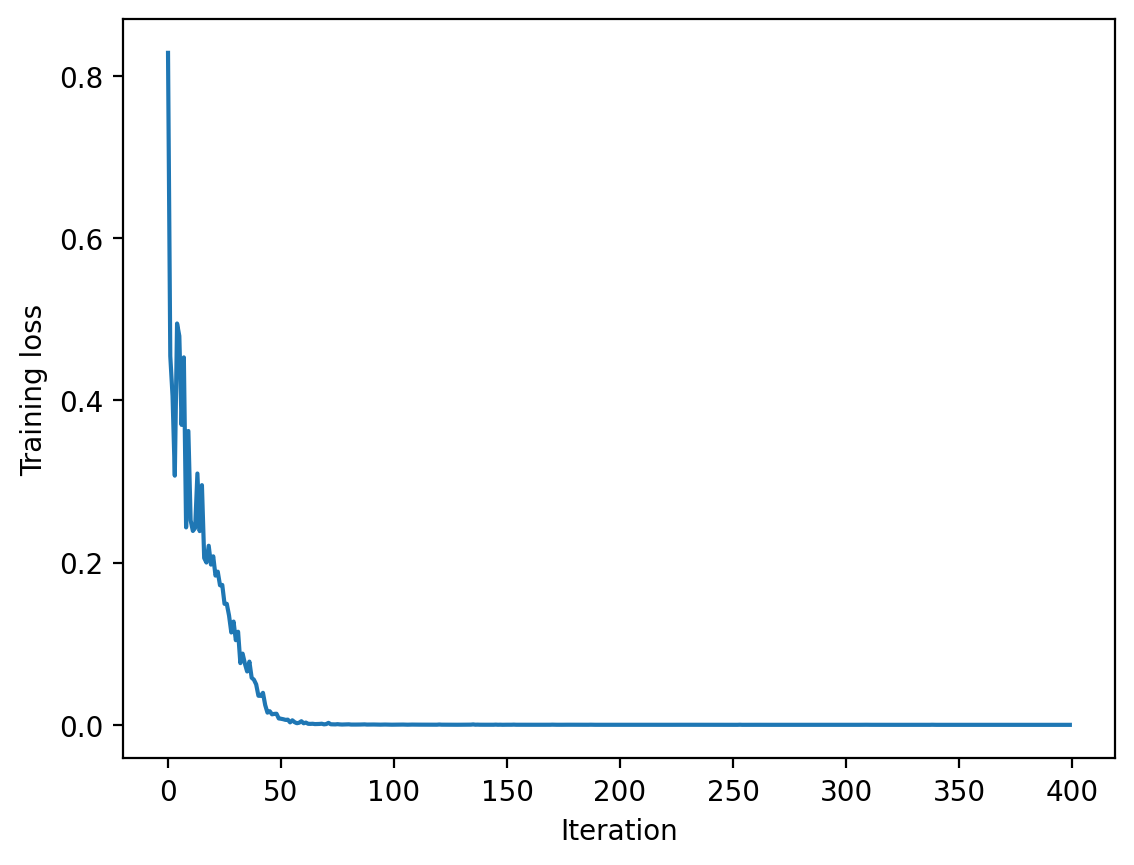

In [41]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

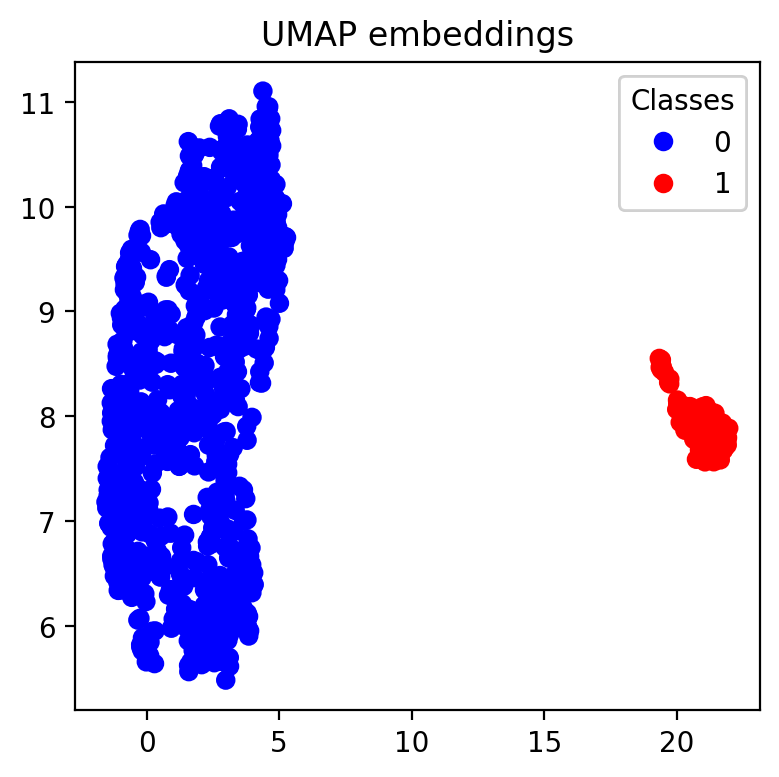

In [42]:
viz_embeddings(net_pretrained, X[train_idx], y[train_idx], device)

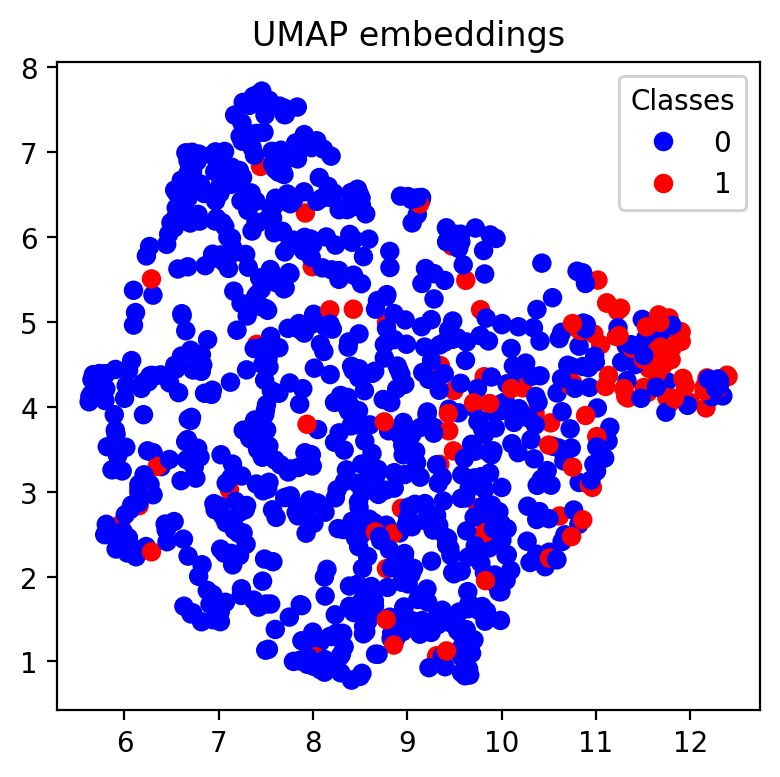

In [43]:
viz_embeddings(net_pretrained, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



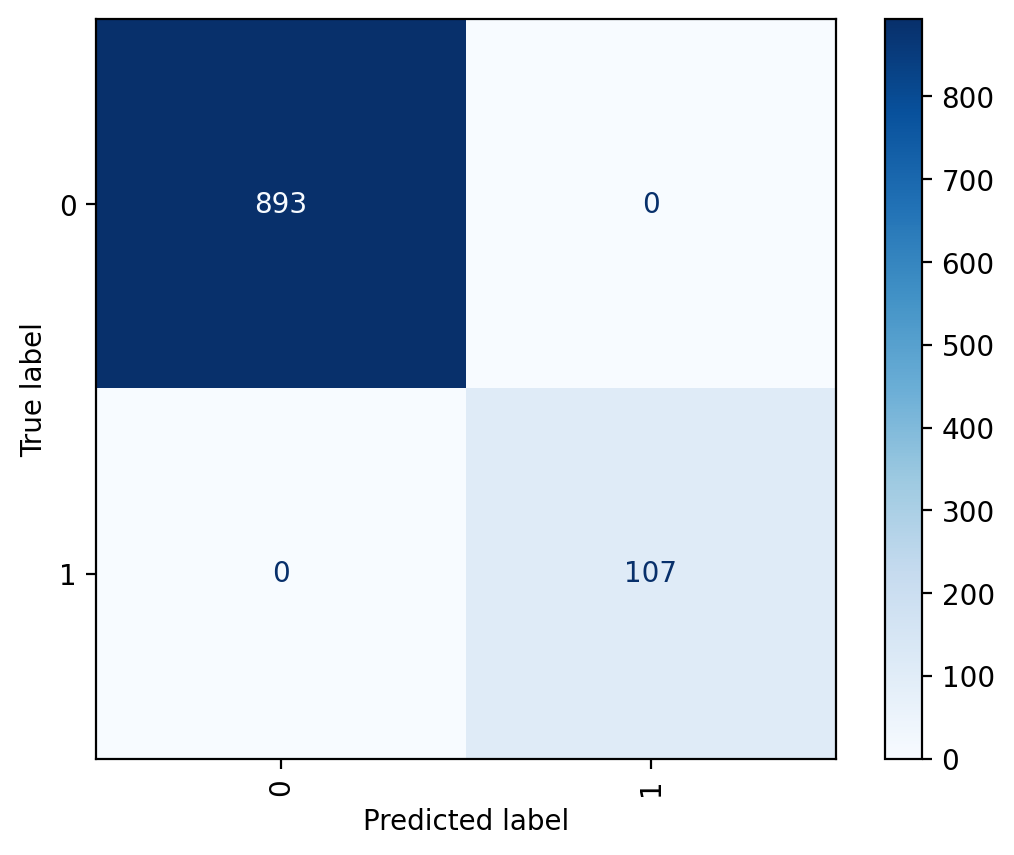

pool set accuracy: 89.71%
39000 39000
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     35115
           1       0.48      0.44      0.46      3885

    accuracy                           0.90     39000
   macro avg       0.71      0.69      0.70     39000
weighted avg       0.89      0.90      0.89     39000



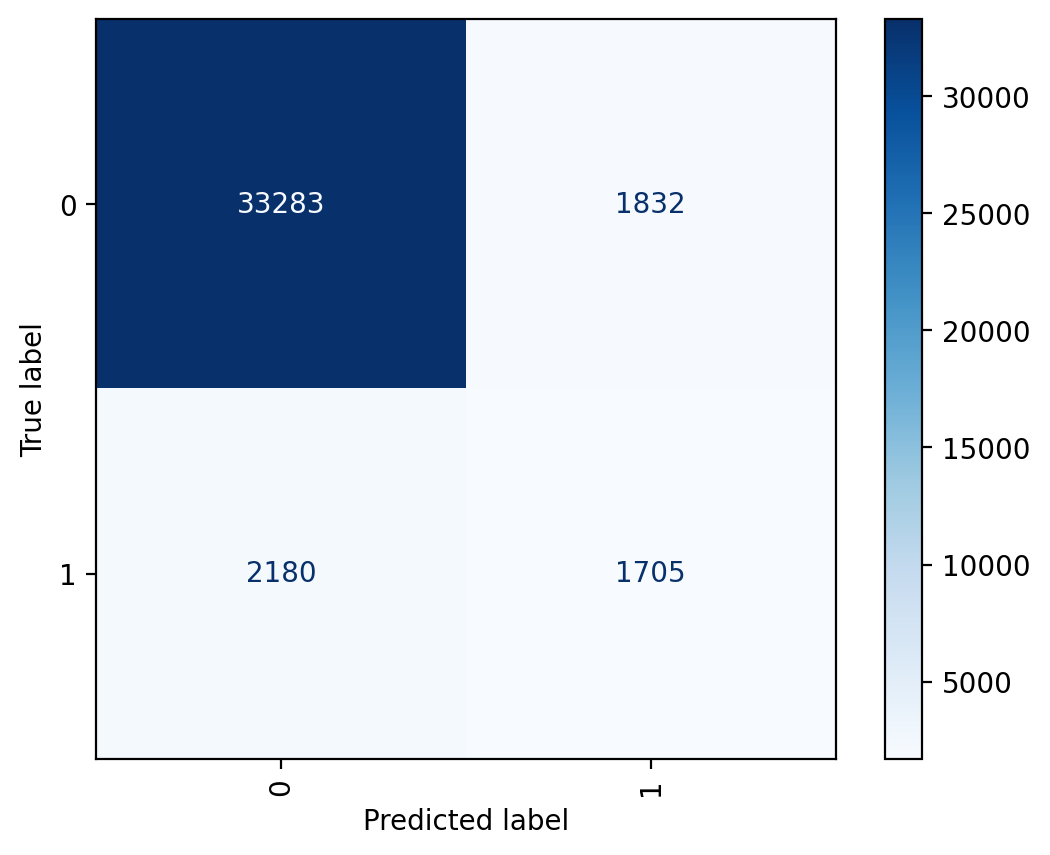

test set accuracy: 89.60%
20000 20000
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     17992
           1       0.48      0.42      0.45      2008

    accuracy                           0.90     20000
   macro avg       0.71      0.69      0.70     20000
weighted avg       0.89      0.90      0.89     20000



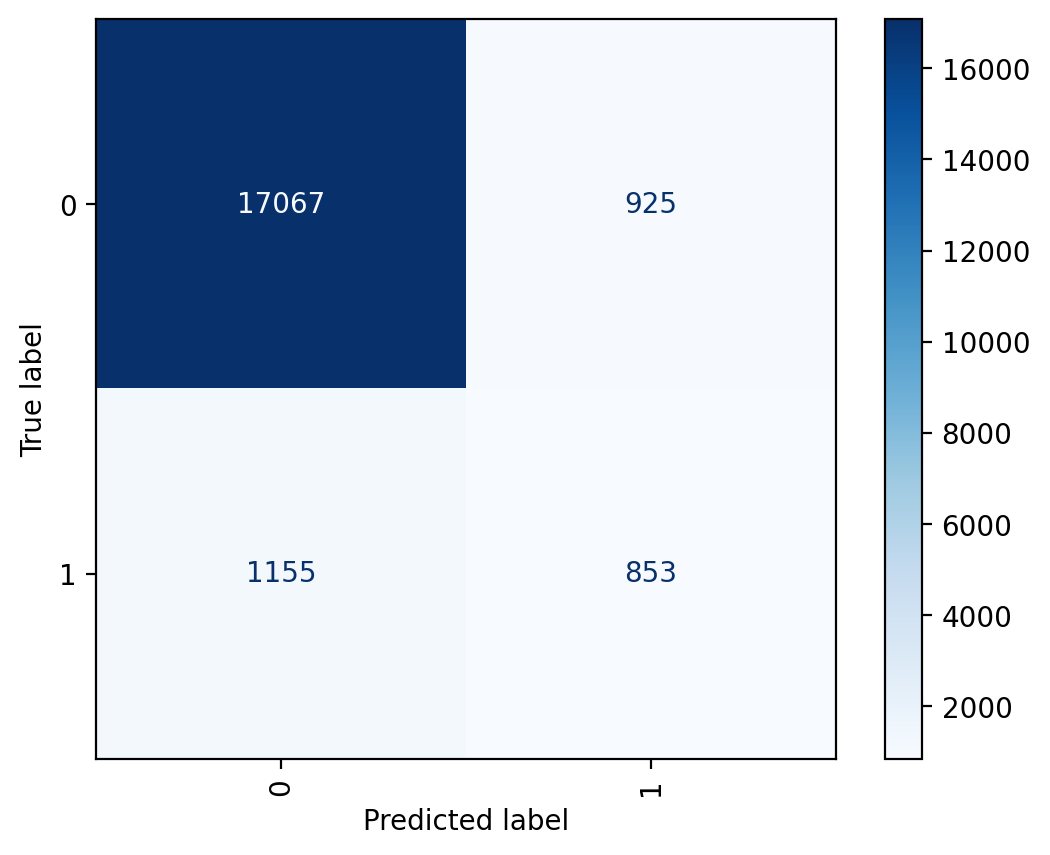

In [44]:
predict(net_pretrained, ["0", "1"], plot_confusion_matrix=True)

In [45]:
dict1

{'Training set': [],
 'train Accuracy': [tensor(13.6000, device='cuda:0'),
  tensor(100., device='cuda:0'),
  tensor(99.8000, device='cuda:0'),
  tensor(100., device='cuda:0')],
 'pool Accuracy': [tensor(13.0128, device='cuda:0'),
  tensor(88.9051, device='cuda:0'),
  tensor(99.7923, device='cuda:0'),
  tensor(89.7128, device='cuda:0')],
 'test Accuracy': [tensor(13.0200, device='cuda:0'),
  tensor(88.5950, device='cuda:0'),
  tensor(93.8100, device='cuda:0'),
  tensor(89.6000, device='cuda:0')],
 'train F1 Score': [0.06695464362850971, 1.0, 0.9988801791713325, 1.0],
 'pool F1 Score': [0.07275808347227158,
  0.9382818183114865,
  0.998846695997608,
  0.9431550908215025],
 'test F1 Score': [0.07181730871838651,
  0.936485395260769,
  0.9657101706182141,
  0.9425636494173525]}

In [46]:
dict1['Training set'] = ['Random Weight Initialization', 'Train set', 'Train + Pool set', 'SSL Permute']

In [56]:
df_results = pd.DataFrame(dict1)

In [54]:
l1 = []
for i in dict1['test Accuracy']:
    l1.append(i.item())
dict1['test Accuracy'] = l1
    

In [55]:
dict1

{'Training set': ['Random Weight Initialization',
  'Train set',
  'Train + Pool set',
  'SSL Permute'],
 'train Accuracy': [13.600000381469727, 100.0, 99.80000305175781, 100.0],
 'pool Accuracy': [13.01282024383545,
  88.9051284790039,
  99.79230499267578,
  89.71282196044922],
 'test Accuracy': [13.019999504089355,
  88.5949935913086,
  93.80999755859375,
  89.5999984741211],
 'train F1 Score': [0.06695464362850971, 1.0, 0.9988801791713325, 1.0],
 'pool F1 Score': [0.07275808347227158,
  0.9382818183114865,
  0.998846695997608,
  0.9431550908215025],
 'test F1 Score': [0.07181730871838651,
  0.936485395260769,
  0.9657101706182141,
  0.9425636494173525]}

In [65]:
df_results.loc[len(df_results.index)] = ['SSL Angle', 100.0, 90.5615, 90.4200, 1.0, 0.947487053654222, 0.9468220927005273]

In [66]:
df_results.drop([4], inplace=True)

KeyError: '[4] not found in axis'

In [67]:
df_results

,Training set,train Accuracy,pool Accuracy,test Accuracy,train F1 Score,pool F1 Score,test F1 Score
0,Random Weight Initialization,13.600000,13.012820,13.020000,0.066955,0.072758,0.071817
1,Train set,100.000000,88.905128,88.594994,1.000000,0.938282,0.936485
2,Train + Pool set,99.800003,99.792305,93.809998,0.998880,0.998847,0.965710
3,SSL Permute,100.000000,89.712822,89.599998,1.000000,0.943155,0.942564
5,SSL Angle,100.000000,90.561500,90.420000,1.000000,0.947487,0.946822
